In [1]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# read
n_LF, n_HF, rel_error = np.loadtxt('error_function_goku_pre_frontera.txt', unpack=True, usecols=(0,1,2))

In [3]:
# extract n_LF < 60
'''n_LF_thres = 60
n_LF_new = []
n_HF_new = []
rel_err_new = []
for i in range(len(n_LF)):
    if n_LF[i] < n_LF_thres:
        n_LF_new.append(n_LF[i])
        n_HF_new.append(n_HF[i])
        rel_err_new.append(rel_error[i])
n_LF = np.array(n_LF_new)
n_HF = np.array(n_HF_new)
rel_error = np.array(rel_err_new)'''

'n_LF_thres = 60\nn_LF_new = []\nn_HF_new = []\nrel_err_new = []\nfor i in range(len(n_LF)):\n    if n_LF[i] < n_LF_thres:\n        n_LF_new.append(n_LF[i])\n        n_HF_new.append(n_HF[i])\n        rel_err_new.append(rel_error[i])\nn_LF = np.array(n_LF_new)\nn_HF = np.array(n_HF_new)\nrel_error = np.array(rel_err_new)'

In [4]:
error_mean = rel_error.mean()
error_var = np.var(rel_error)

In [53]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    eta = pm.Normal("eta", mu=10, sigma=.3)
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = pm.LogNormal("rho", mu=22, sigma=1)
    beta_L = pm.Normal("beta_L", mu=1, sigma=.2)
    beta_H = pm.Normal("beta_H", mu=2, sigma=.2)
    # rho_2 = pm.Uniform("rho_2", lower=0, upper=1)
    beta_H2 = pm.Normal("beta_H2", mu=2, sigma=1)
    # alpha_1 = pm.Normal("alpha_1", mu=10, sigma=5)
    alpha_L = pm.Normal("alpha_L", mu=30, sigma=5)
    alpha_1 = pm.Normal("alpha_1", mu=30, sigma=5)
    alpha_2 = pm.Normal("alpha_2", mu=5, sigma=5)
    # rho_H = pm.Normal("rho_H", mu=1, sigma=.2)

    sigma = pm.HalfNormal("sigma", sigma=.1)

    # Expected value of outcome
    mu = np.log10(eta) + np.log10(rho / ( (n_LF + n_HF) * (n_LF + alpha_L)**(beta_L-1) * (n_HF + alpha_1)**(beta_H-1) ) + 1 / (alpha_2 + n_HF)**(beta_H2))

    # Likelihood (sampling distribution) of observations
    rel_error_obs = pm.Normal("rel_error_obs", mu=mu, sigma=sigma, observed=np.log10(rel_error))

In [54]:
error_mean

0.07691774833501684

In [55]:
with basic_model:
    # draw 2000 posterior samples
    # idata = pm.sample(2000, tune=1000)
    idata = pm.sample(6000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, rho, beta_L, beta_H, beta_H2, alpha_L, alpha_1, alpha_2, sigma]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 319 seconds.


In [56]:
dict(idata)

{'posterior': <xarray.Dataset> Size: 2MB
 Dimensions:  (chain: 4, draw: 6000)
 Coordinates:
   * chain    (chain) int64 32B 0 1 2 3
   * draw     (draw) int64 48kB 0 1 2 3 4 5 6 ... 5994 5995 5996 5997 5998 5999
 Data variables:
     alpha_1  (chain, draw) float64 192kB 22.17 25.25 22.75 ... 24.71 25.26 21.82
     alpha_2  (chain, draw) float64 192kB 4.129 14.05 3.399 ... 6.07 5.733 8.58
     alpha_L  (chain, draw) float64 192kB 31.47 33.85 30.44 ... 21.29 31.29 31.89
     beta_H   (chain, draw) float64 192kB 4.599 4.91 4.563 ... 4.921 4.958 4.565
     beta_H2  (chain, draw) float64 192kB 3.213 2.069 2.505 ... -0.1087 2.949
     beta_L   (chain, draw) float64 192kB 1.108 1.1 1.141 ... 1.131 1.096 1.115
     eta      (chain, draw) float64 192kB 9.966 10.13 9.973 ... 9.966 10.65 10.36
     rho      (chain, draw) float64 192kB 3.333e+05 1.3e+06 ... 2.832e+05
     sigma    (chain, draw) float64 192kB 0.2138 0.21 0.2184 ... 0.2184 0.2179
 Attributes:
     created_at:                 2024-07

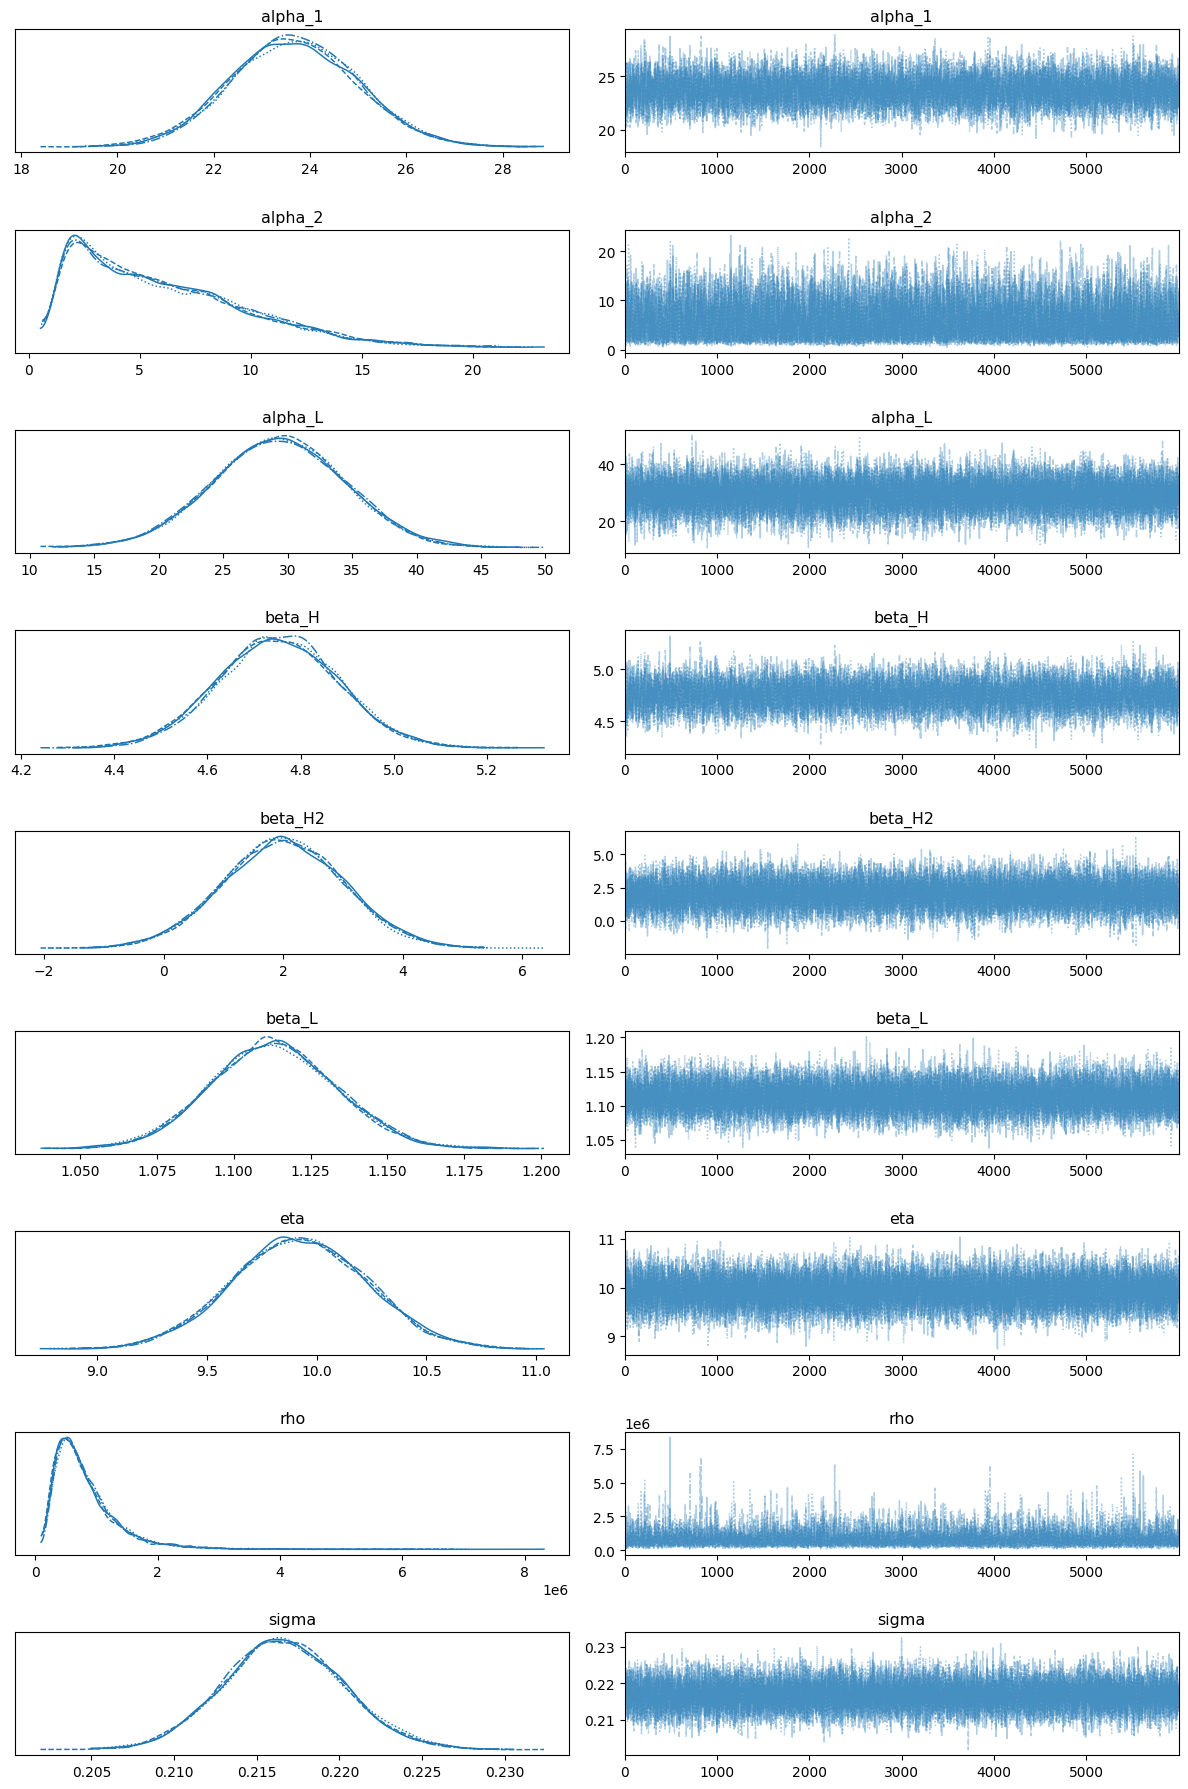

In [57]:
az.plot_trace(idata)
plt.tight_layout()

In [58]:
posterior_eta = idata["posterior"]["eta"]
credible_interval_eta = np.percentile(posterior_eta, [16, 50, 84])
posterior_rho = idata["posterior"]["rho"]
credible_interval_rho = np.percentile(posterior_rho, [16, 50, 84])
posterior_beta_L = idata["posterior"]["beta_L"]
credible_interval_beta_L = np.percentile(posterior_beta_L, [16, 50, 84])
posterior_beta_H = idata["posterior"]["beta_H"]
credible_interval_beta_H = np.percentile(posterior_beta_H, [16, 50, 84])
print(credible_interval_eta)
print(credible_interval_rho)
print(credible_interval_beta_L)
print(credible_interval_beta_H)


[ 9.62037312  9.92117565 10.22679994]
[ 380928.24843412  687547.95030474 1241058.76404685]
[1.09261042 1.11254667 1.13321486]
[4.62393254 4.75157026 4.88013161]


In [59]:
az.summary(idata, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_1,23.687,1.306,21.199,26.086,0.015,0.010,7844.055,11819.111,1.001
alpha_2,6.004,3.784,0.907,12.924,0.041,0.029,9065.849,11732.574,1.000
alpha_L,29.304,5.094,19.515,38.562,0.036,0.026,19840.997,16925.537,1.000
beta_H,4.752,0.129,4.498,4.984,0.001,0.001,7639.141,10740.746,1.001
beta_H2,2.004,1.005,0.122,3.909,0.007,0.005,18103.637,15809.752,1.000
beta_L,1.113,0.020,1.076,1.152,0.000,0.000,19576.388,17144.014,1.001
eta,9.922,0.303,9.316,10.456,0.002,0.002,18113.793,15714.227,1.000
rho,821032.848,540770.222,132497.754,1740619.616,6011.648,4251.030,7494.030,10732.999,1.001
sigma,0.217,0.004,0.210,0.224,0.000,0.000,21934.691,17436.684,1.000


In [60]:
posterior_eta.values.flatten()

array([ 9.96605774, 10.12741632,  9.97347184, ...,  9.96642674,
       10.65192239, 10.3633214 ])

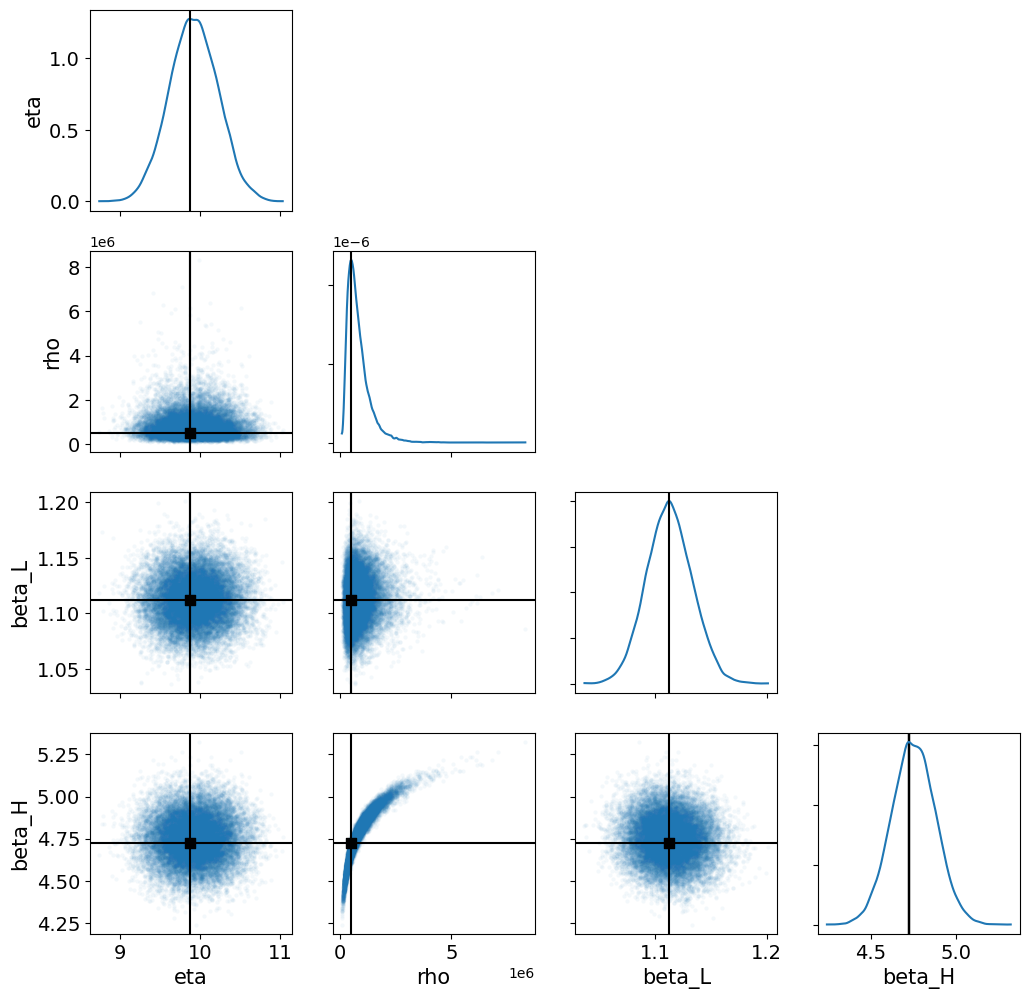

In [61]:
az.plot_pair(
    idata,
    marginals=True,
    point_estimate="mode",
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.05},
    var_names=["eta", "rho", "beta_L", "beta_H"],
);

In [78]:
# define the error function 7
def error_function(n_LF, n_HF):
    eta = 10.063	
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = 821032
    beta_L = 1.113
    beta_H = 4.752
    # rho_2 = pm.Uniform("rho_2", lower=0, upper=1)
    # beta_H2 = 3.486
    # alpha_1 = pm.Normal("alpha_1", mu=10, sigma=5)
    alpha_L = 29.304
    alpha_1 = 23.687
    alpha_2 = 6.004

    sigma_lg_Phi = 0.217	   # standard deviation of the log of the error function
    # return 10**(np.log10(eta) + np.log10((rho / (n_LF**(beta_L) * n_HF**(beta_H)) + (1 - rho) / (alpha + n_HF**(beta_H2)))))
    lg_Phi = np.log10(eta) + np.log10(rho / ( (n_LF + n_HF) * (n_LF + alpha_L)**(beta_L-1) * (n_HF + alpha_1)**(beta_H-1) ) + 1 / (alpha_2 + n_HF)**(beta_H))
    
    mode_Phi = 10**lg_Phi * np.exp(-sigma_lg_Phi**2 * (np.log(10))**2)
    mean_Phi = 10**lg_Phi * np.exp(1/2 * (sigma_lg_Phi * np.log(10))**2)
    median_Phi = 10**lg_Phi
    return median_Phi

In [79]:
# loss  mean
eta_mean = np.mean(idata["posterior"]["eta"].values)
rho_mean = np.mean(idata["posterior"]["rho"].values)
beta_L_mean = np.mean(idata["posterior"]["beta_L"].values)
beta_H_mean = np.mean(idata["posterior"]["beta_H"].values)

lg_phi = np.log10(error_function(n_LF, n_HF))
loss = np.mean((lg_phi - rel_error)**2)

In [80]:
loss

2.3040616620219163

In [81]:
type(idata["posterior"]["eta"])

xarray.core.dataarray.DataArray

In [82]:
# define the error function
def error_function(n_LF, n_HF):
    eta = 0.55464788
    rho = 2.42445591
    beta_L = 0.71932452
    beta_H = 1.40160385
    return eta * (rho * n_LF**(-beta_L) + n_HF**(-beta_H))


In [83]:
error_function(60, 9)

0.09622394048841161